In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import h5py
import seaborn
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import pairwise_distances
import sys
sys.path.append("../")
from utils import l2_normalize, prewhiten, read_sampled_identities
from PIL import Image
seaborn.set()

In [73]:
def recall_given_dist(
    dist_self,
    dist_negative,
    k
):
    dist_self = np.sort(dist_self)
    dist_negative = np.sort(dist_negative)
    i = 0.0
    i_self = 0
    i_neg = 0
    recall_count = 0.0
    while i < k:  
        if dist_self[i_self] < dist_negative[i_neg]:
            recall_count += 1.0
            i_self += 1
        else:
            i_neg += 1

        i += 1.0

        if i_self >= len(dist_self):
            break

        if i_neg >= len(dist_negative):
            total_true = min(float(len(dist_self)), k - i)
            remaining_true = max(total_true - i_self, 0.0)
            recall_count += remaining_true
            break
    final = recall_count / min(len(dist_self), k)

    return final

def recall(
    base_embeddings, 
    negative_embeddings,
    k
):
    self_distances = pairwise_distances(
        base_embeddings,
        base_embeddings
    )
    
    negative_distances = pairwise_distances(
        base_embeddings,
        negative_embeddings
    )
    
    recall = []
    for indx, dist_self in enumerate(self_distances):
        dist_self = np.delete(dist_self, indx)
        dist_negative = negative_distances[indx]
        r = recall_given_dist(dist_self, dist_negative, k)
        recall.append(r)
    return np.mean(recall)

def recall_for_target(
    adversarial_target, 
    identities,
    epsilons, 
    path_to_adversarial, 
    path_to_clean,
    ks
):
    query_embeddings = []
    adv = {eps: [] for eps in epsilons}
    with h5py.File(path_to_clean.format(id=adversarial_target), "r") as f:
        query_embeddings.extend(f["embeddings"][:])

    for modified_identity in identities:
        if modified_identity == adversarial_target:
            continue
        for indx, epsilon in enumerate(epsilons):
            if epsilon == 0.0:
                with h5py.File(path_to_clean.format(id=modified_identity), "r") as f:
                    adv[epsilon].extend(f["embeddings"][:])
            else:
                with h5py.File(path_to_adversarial.format(
                    target=adversarial_target,
                    true=modified_identity,
                    epsilon=epsilon
                ), "r") as f:
                    adv[epsilon].extend(f["embeddings"][:])
    
    return [[recall(query_embeddings, adv[epsilon], k) for epsilon in epsilons] for k in ks]
      

In [74]:
def plot_recall(
    path_to_adversarial="/data/vggface/test_perturbed_sampled/{true}/community_naive_same/{target}/epsilon_{epsilon}.h5",
    path_to_clean="/data/vggface/test_preprocessed_sampled/{id}/embeddings.h5",
    epsilons=[0.0, 0.02, 0.04, 0.06, 0.08, 0.1],
    identities=read_sampled_identities("../sampled_identities.txt").keys(),
    ks=[1, 5, 10, 100, 1000],
    colors=['#0017ad', '#2d67ed', '#37a0f0', '#37e6f0','#000000']
):
    recall_for_targets = np.ones((len(identities), len(ks), len(epsilons))) * (-1.0)
    
    for indx, identity in enumerate(identities):
        recall_for_targets[indx, :, :] = recall_for_target(
            identity,
            identities,
            epsilons,
            path_to_adversarial,
            path_to_clean,
            ks
        )
    
    recall_for_targets = np.mean(recall_for_targets, axis=0)
    
    fig, ax = plt.subplots(nrows=1, ncols=1)

    for indx, k in enumerate(ks):
        ax.plot(
            list(epsilons),
            recall_for_targets[indx],
            label="k={}".format(k),
            color=colors[indx],
        )

    ax.set_ylabel("Recall Percentage")
    ax.set_xlabel("Epsilon (Perturbation Amount)")
    ax.set_title("Recall from top hits community_naive_same")
    ax.set_ylim([-0.1, 1.1])
    ax.legend()
    plt.show()
        

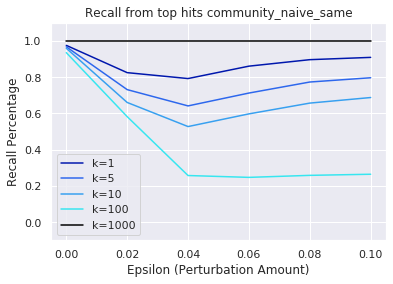

In [75]:
plot_recall()

# Tests for recall function

In [ ]:
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 100) == 1.0)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 100) == 1.0)
print(recall_given_dist([0.0, 1.8], [1.5, 1.6], 100) == 1.0)
print()
print(recall_given_dist([0.0, 1.8], [1.5, 1.6], 2) == 0.5)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 2) == 1.0)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 2) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 2) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [0.4, 1.6], 2) == 0.5)
print(recall_given_dist([0.5, 1.0], [0.4, 0.3], 2) == 0.0)
print()
print(recall_given_dist([0.0, 1.8], [1.5, 1.6], 4) == 0.5)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 4) == 1.0)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 4) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 4) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [0.4, 1.6], 4) == 1.0)
print(recall_given_dist([0.5, 1.0], [0.4, 0.3], 4) == 1.0)
print()
print(np.abs(recall_given_dist([0.0, 1.8], [1.5, 1.6], 3) - 0.5) < 1e-3)
print(np.abs(recall_given_dist([0.0, 1.0], [1.5, 1.6], 3)) == 1.0)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 3) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 3) == 1.0)
print(np.abs(recall_given_dist([0.0, 1.0], [0.4, 1.6], 3)) == 1.0)
print(recall_given_dist([0.5, 1.0], [0.4, 0.3], 3) == 0.5)
print()
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 1) == 1.0)
print(np.abs(recall_given_dist([0.0, 1.0], [0.4, 1.6], 1)) == 1.0)
print(recall_given_dist([0.5, 1.0], [0.4, 0.3], 1) == 0.0)
print()
print(recall_given_dist([0.0, 0.1, 0.2], [0.3, 0.4, 0.5], 5) == 1.0)
print(np.abs(recall_given_dist([0.0, 0.1, 0.2, 0.3, 0.4], [0.5, 1.6], 5)) == 1.0)
print(np.abs(recall_given_dist([0.0, 1.1, 0.2, 0.3, 0.4], [0.4, 1.6], 5)) == 0.8)
print()
print(recall_given_dist([0.0, 0.1, 0.2], [0.3, 0.4, 0.5], 1) == 1.0)
print(np.abs(recall_given_dist([0.0, 0.1, 0.2, 0.3, 0.4], [0.5, 1.6], 1)) == 1.0)
print(np.abs(recall_given_dist([0.0, 1.1, 0.2, 0.3, 0.4], [0.4, 1.6], 1)) == 1.0)

In [147]:
def debug_recall(
    adversarial_target="n000029",
    epsilon=0.0,
    k=5
):
    path_to_adversarial="/data/vggface/test_perturbed_sampled/{true}/community_naive_same/{target}/epsilon_{epsilon}.h5"
    path_to_clean="/data/vggface/test_preprocessed_sampled/{id}/embeddings.h5"
    
    query_embeddings = []
    adv = {eps: [] for eps in epsilons}
    identities=read_sampled_identities("../sampled_identities.txt").keys()

    with h5py.File(path_to_clean.format(id=adversarial_target), "r") as f:
        query_embeddings.extend(f["embeddings"][:])

    for modified_identity in identities:
        if modified_identity == adversarial_target:
            continue
        if epsilon == 0.0:
            with h5py.File(path_to_clean.format(id=modified_identity), "r") as f:
                adv[epsilon].extend(f["embeddings"][:])
        else:
            with h5py.File(path_to_adversarial.format(
                    target=adversarial_target,
                    true=modified_identity,
                    epsilon=epsilon
                ), "r") as f:
                    adv[epsilon].extend(f["embeddings"][:])
        
    self_distances = pairwise_distances(query_embeddings, query_embeddings)
    negative_distances = pairwise_distances(query_embeddings, adv[epsilon])
    
    n_clean = len(query_embeddings)
    n_rows = int(np.sqrt(n_clean))
    fig, ax = plt.subplots(ncols=n_rows, nrows=n_rows+1, figsize=(30, 30))
    for indx in range(n_clean):
        dist_self = np.sort(np.delete(self_distances[indx], indx))[:k]
        dist_neg = np.sort(negative_distances[indx])[:k]
        row = indx // n_rows
        col = indx % n_rows
        ax[row][col].plot(range(min(k, len(dist_self))), dist_self, 'go')
        ax[row][col].plot(range(min(k, len(dist_neg))), dist_neg, 'ro')
        
        ax[row][col].set_ylabel("Distance to image".format(indx))
        ax[row][col].set_xlabel("Top nth image")
        ax[row][col].set_title("Image index {} recall@{}={:.2f}".format(
            indx, k, recall_given_dist(dist_self, dist_neg, k)))
        ax[row][col].set_ylim([-0.1, 1.4])
    fig.tight_layout(pad=3.0, rect=[0, 0.03, 1, 0.95])
    fig.suptitle("Closest {} images to each image of {} at epsilon={}".format(
        k, adversarial_target, epsilon
    ), fontsize=36)
    plt.show()
    


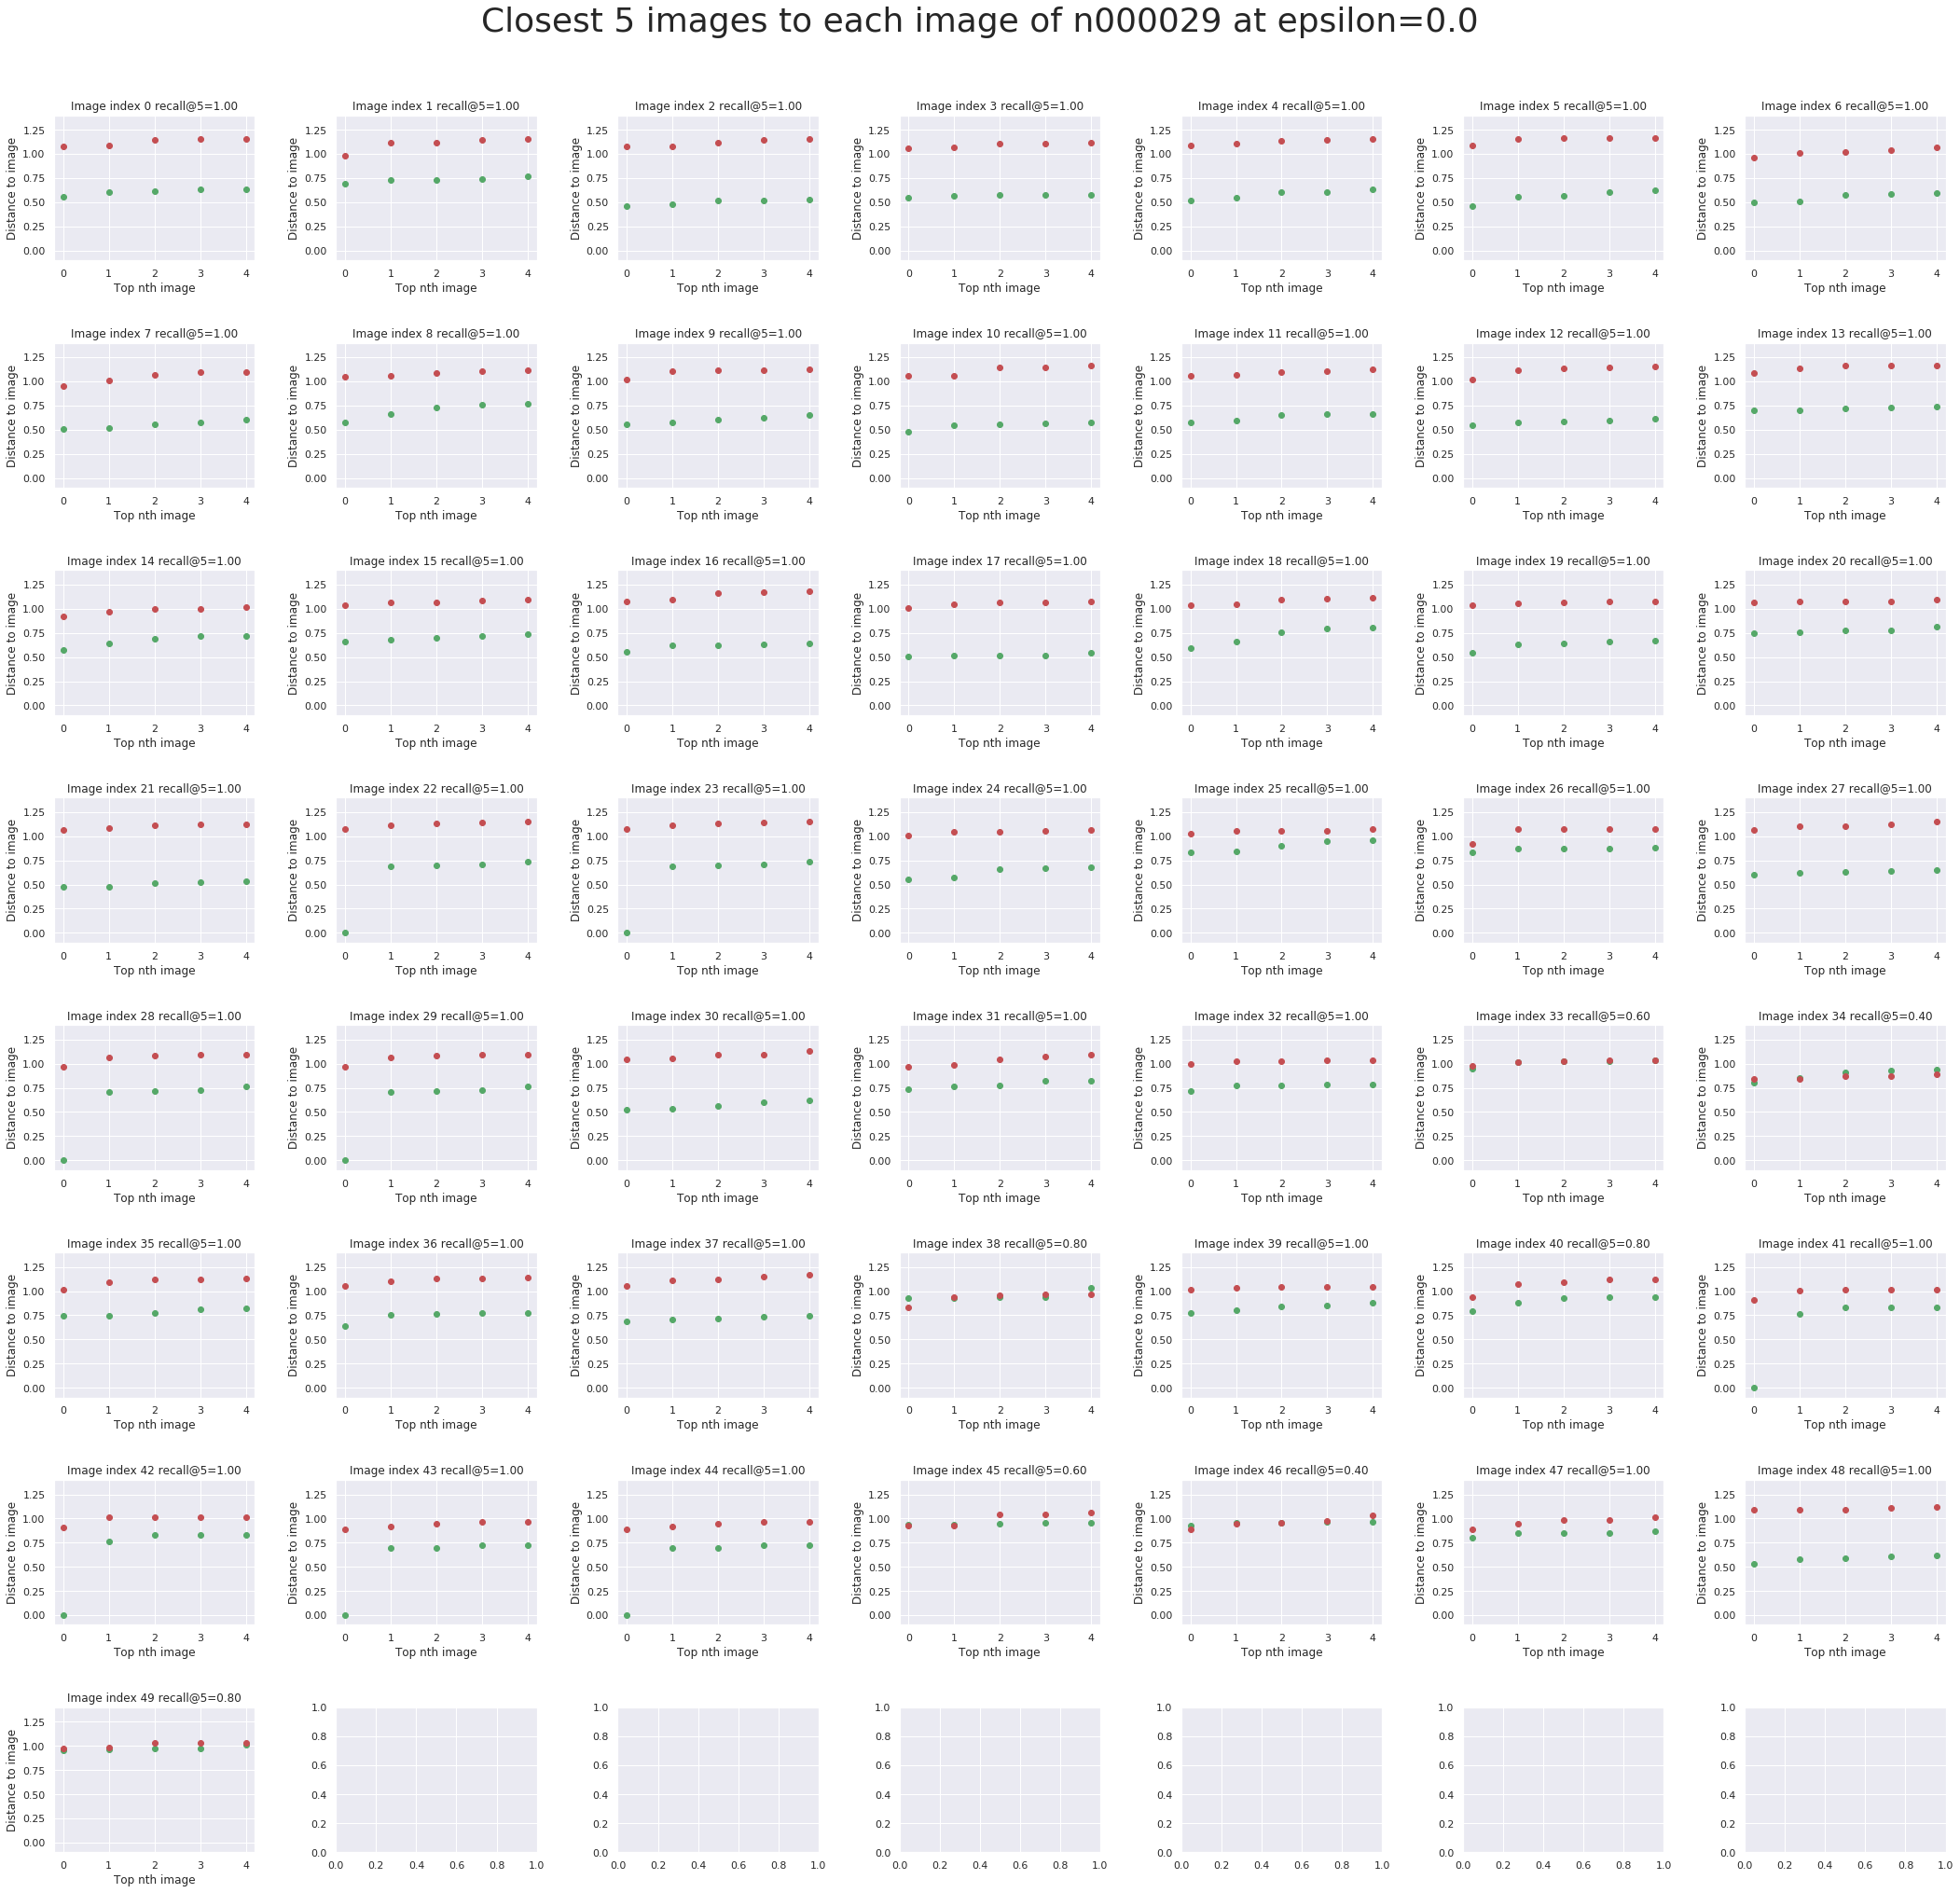

In [148]:
debug_recall()

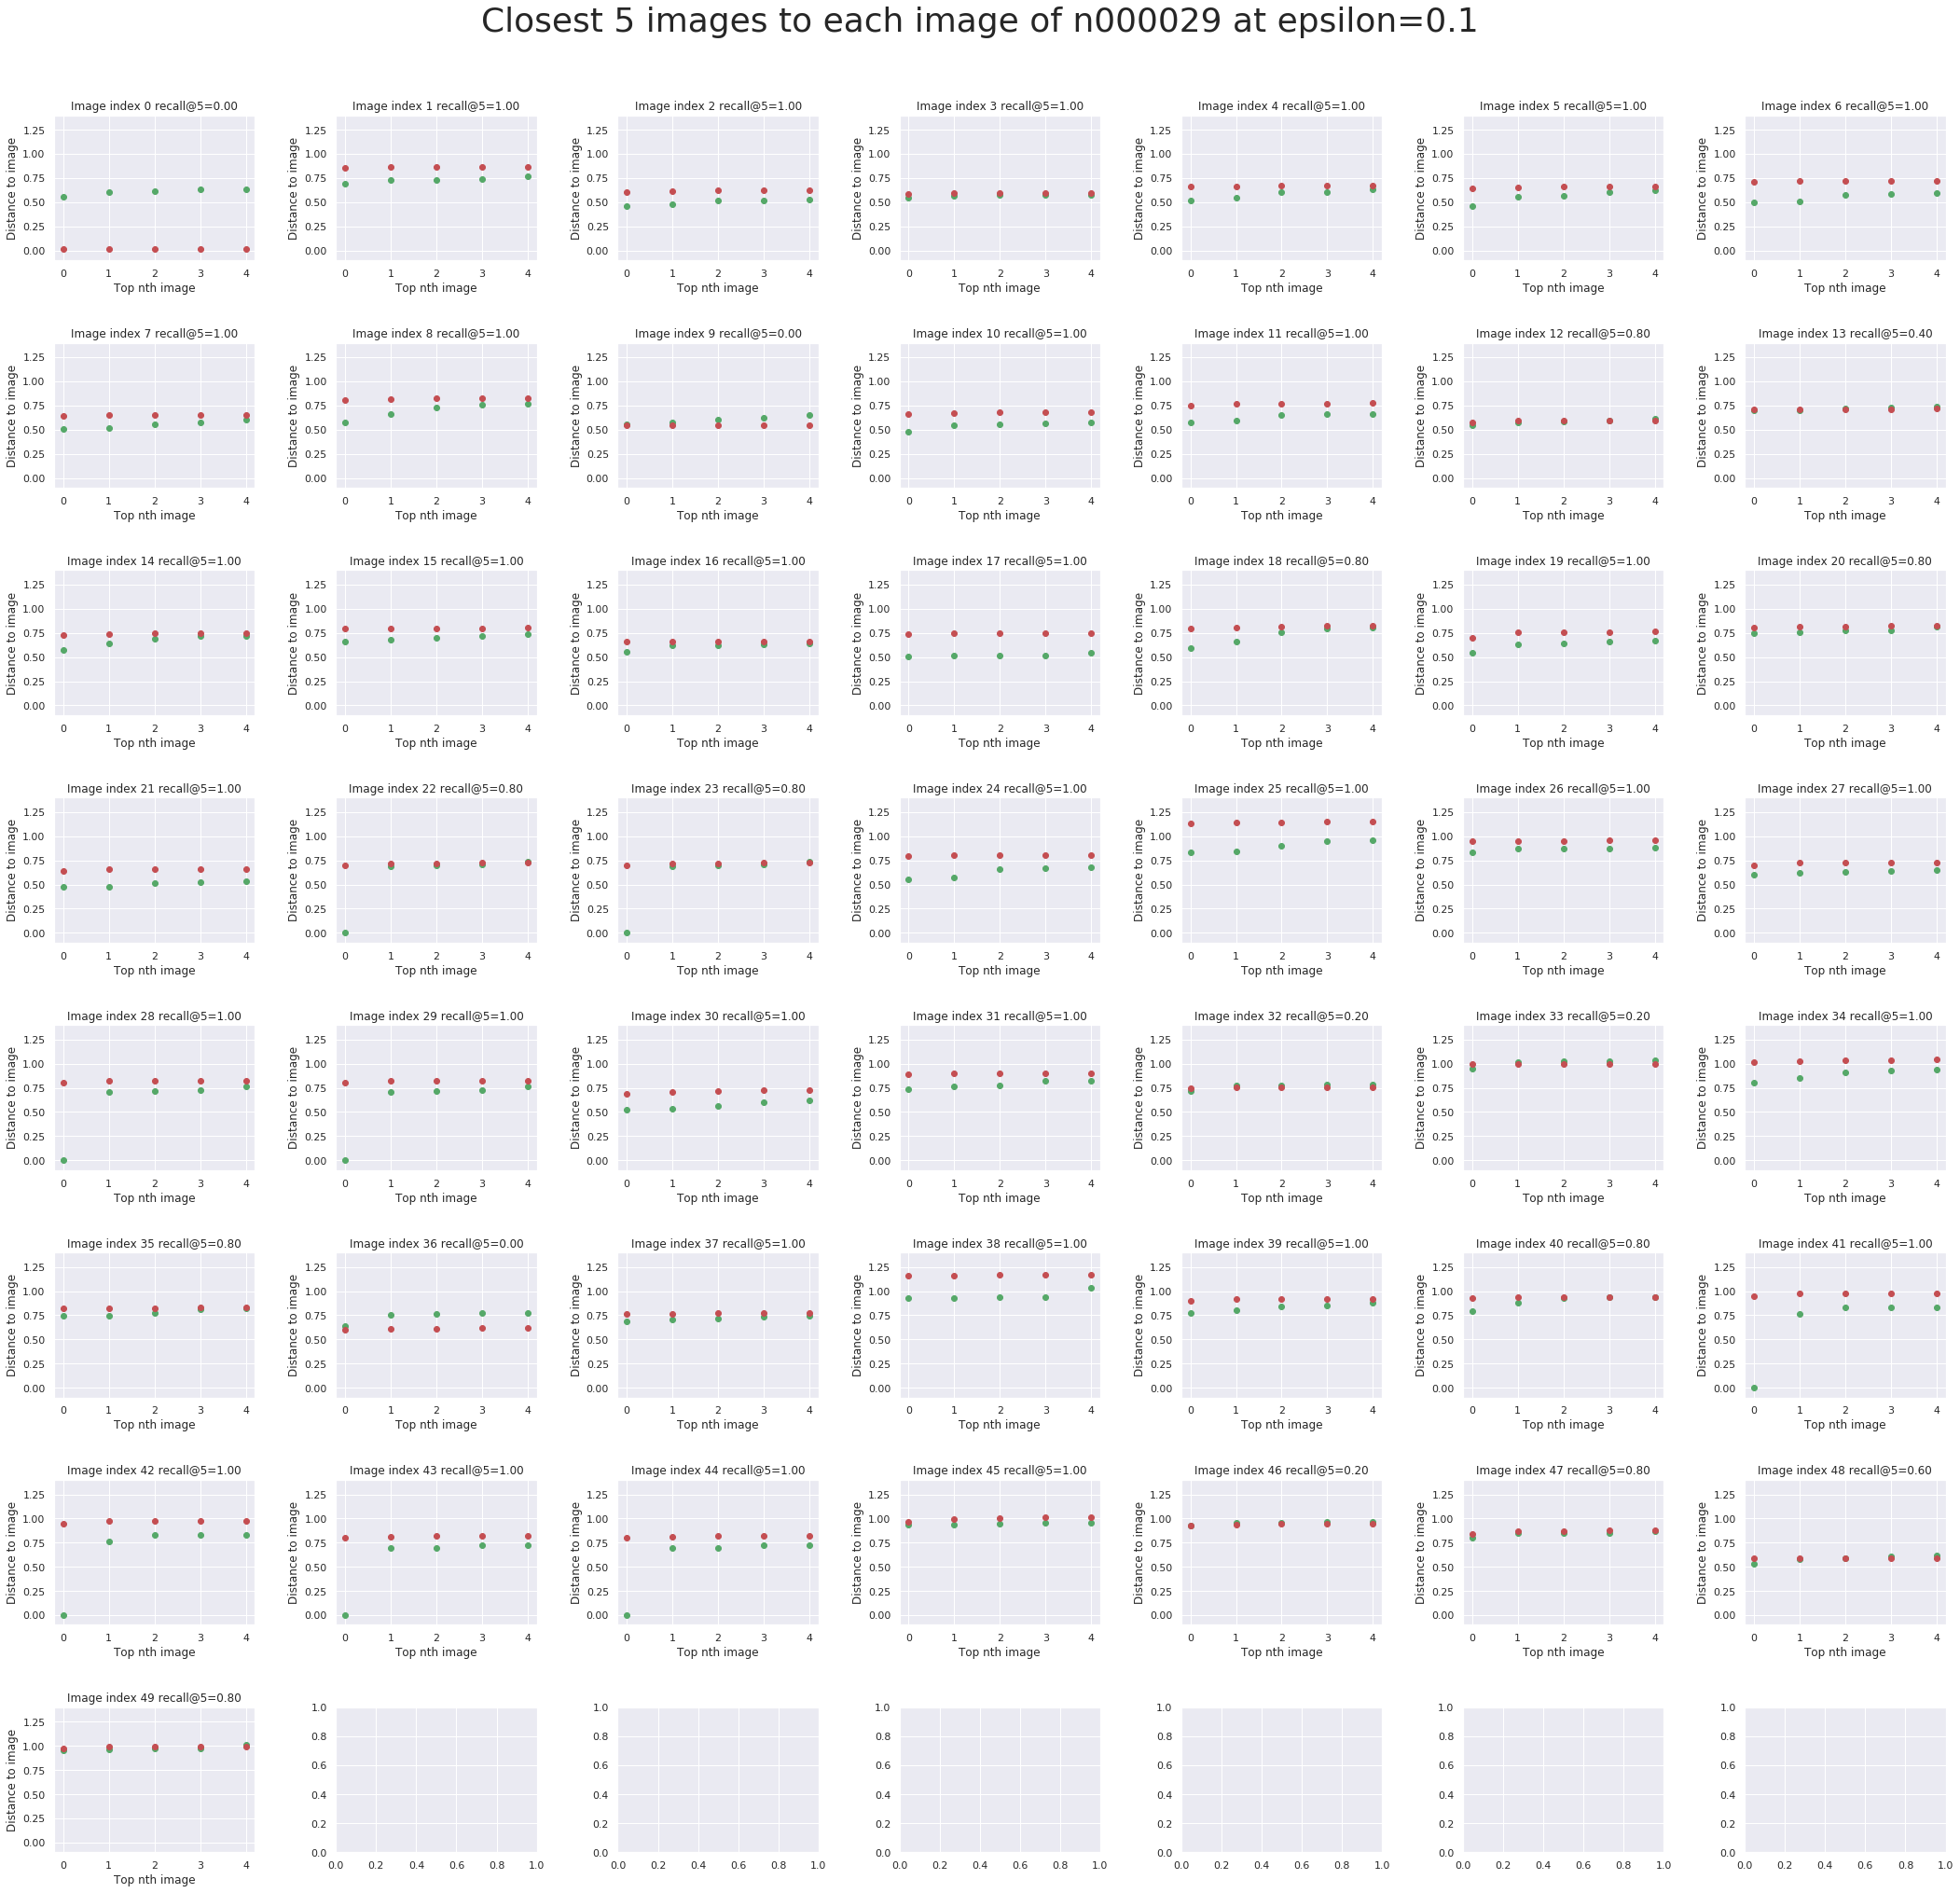

In [149]:
debug_recall(k=5, epsilon=0.1)

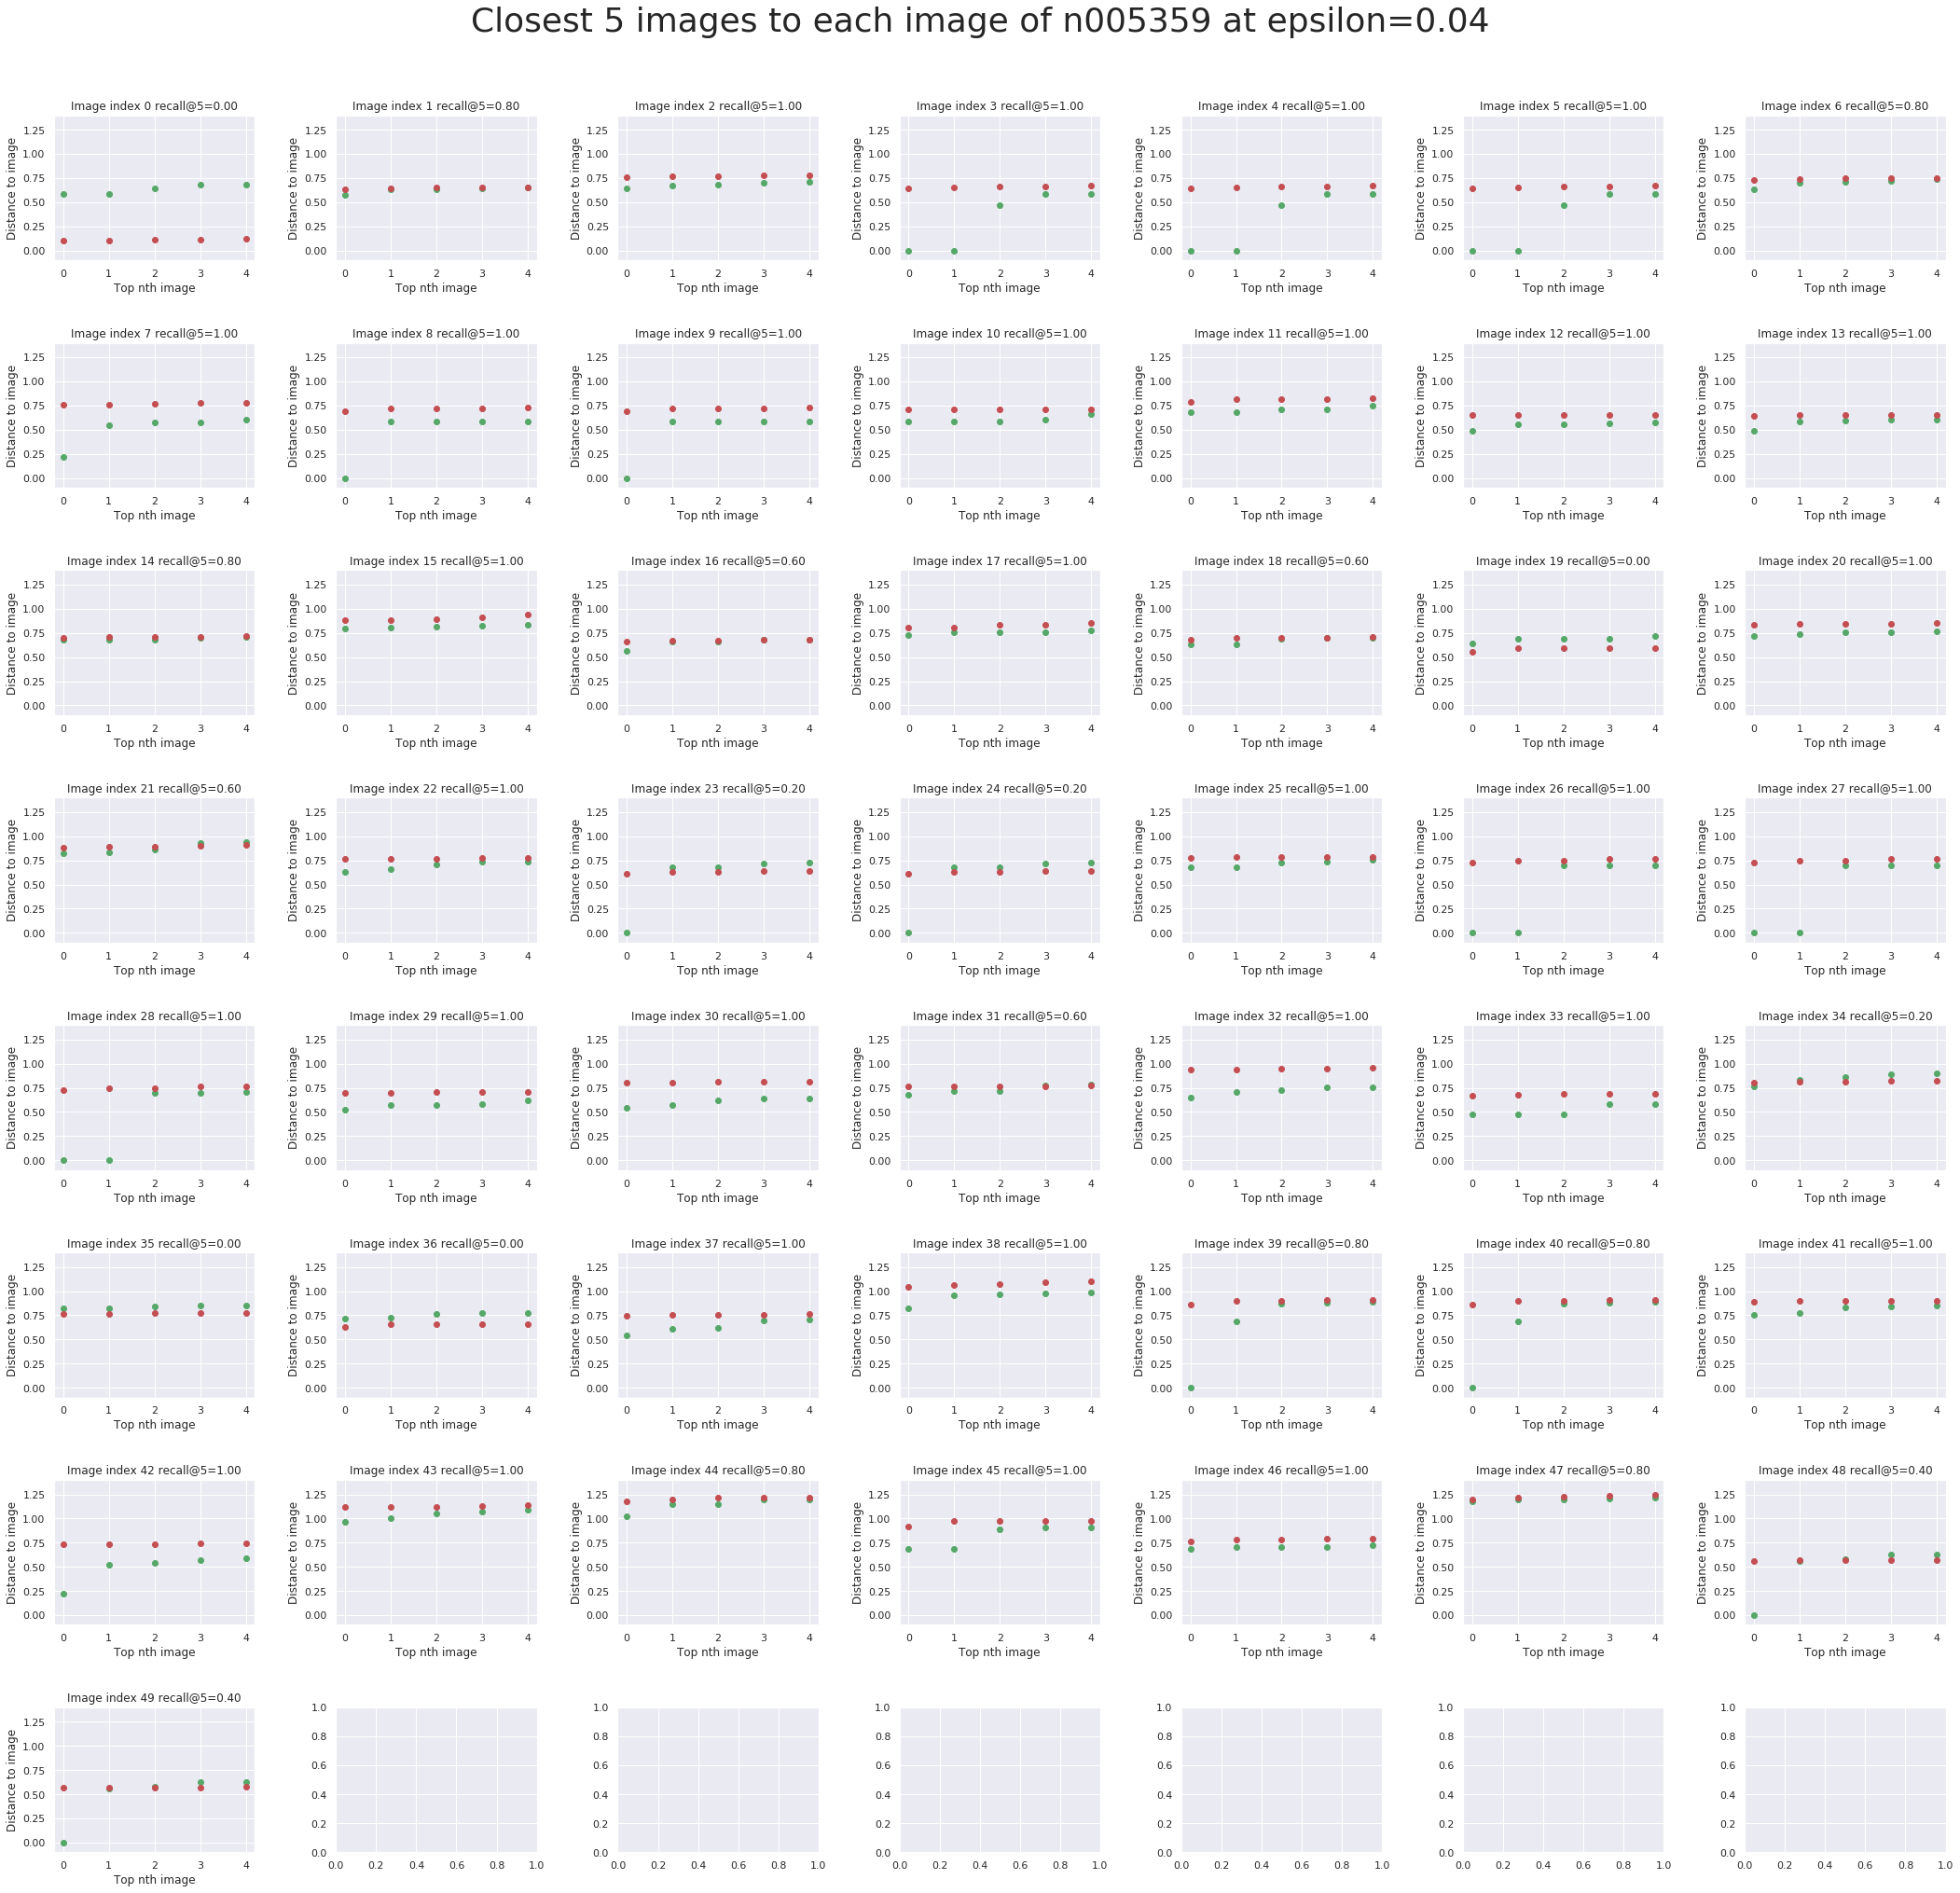

In [150]:
debug_recall(adversarial_target="n005359", epsilon=0.04)

In [ ]:
debug_recall(adversarial_target="n005359", epsilon=0.04, k=100)